In [1]:
# Cell 1: Import Libraries and Set Up Environment
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, TimeDistributed
from tensorflow.keras.losses import binary_crossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


C:\Users\annek\AppData\Local\Temp\ipykernel_2296\3054371191.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_2296\3054371191.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_2296\3054371191.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


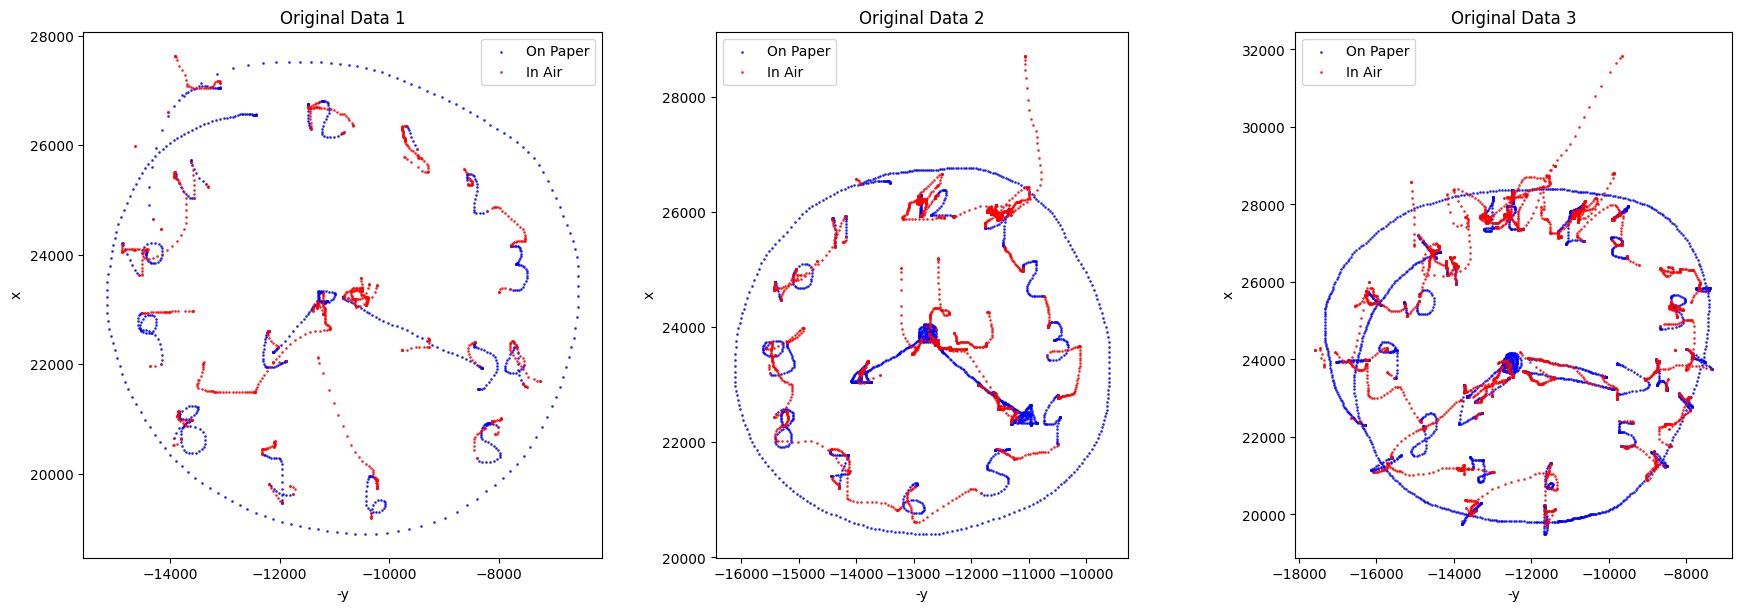

Processed data shape: (10971, 3)
Average number of data points: 3657


In [23]:
# Cell 2: Data Upload, Normalization, and Visualization
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task6'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=3)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [24]:
# Cell 3: Define encoder and decoder

# Sampling layer (needed for reparameterization trick)
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder model
encoder_inputs = Input(shape=(combined_data.shape[1],))
x = Dense(64, activation='relu')(encoder_inputs)
x = Dense(32, activation='relu')(x)
z_mean = Dense(16, name='z_mean')(x)
z_log_var = Dense(16, name='z_log_var')(x)
encoder = Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

# Decoder model
latent_inputs = Input(shape=(16,))
x = Dense(32, activation='relu')(latent_inputs)
x = Dense(64, activation='relu')(x)
decoder_outputs = Dense(combined_data.shape[1], activation='sigmoid')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# Display encoder and decoder summaries
encoder.summary()
decoder.summary()

# Continue with VAE definition
class VAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, inputs):
        # Ensure inputs are a single tensor
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()((z_mean, z_log_var))
        reconstructed = self.decoder(z)
        return reconstructed

    def compute_loss(self, inputs):
        # Ensure inputs are a single tensor
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()((z_mean, z_log_var))
        reconstructed = self.decoder(z)

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(tf.square(inputs - reconstructed))

        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        
        # Combined loss
        vae_loss = tf.reduce_mean(reconstruction_loss + self.beta * kl_loss)

        return vae_loss

    def train_step(self, data):
        # Ensure that data is a single tensor
        data = data[0]  # Extract the tensor if it's provided as a tuple
        with tf.GradientTape() as tape:
            loss = self.compute_loss(data)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

# Build and compile VAE model
vae = VAE(encoder, decoder, beta=1.0)
vae.compile(optimizer=Adam())
vae.summary()

# Train VAE
history = vae.fit(combined_data, combined_data, epochs=10, batch_size=32, verbose=1)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 64)        │        256 │ input_layer_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 32)        │      2,080 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        528 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        528 │ dense_36[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,392 (13.25 KB)

 Trainable params: 3,392 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "vae_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 16), (None,    │         3,392 │
│                                 │ 16)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 3)              │         2,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,243 (24.39 KB)

 Trainable params: 6,243 (24.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1237
Epoch 2/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1184
Epoch 3/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1183
Epoch 4/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1182
Epoch 5/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1182
Epoch 6/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1181
Epoch 7/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1181
Epoch 8/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1181
Epoch 9/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1180
Epoch 10/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1181


In [25]:
# Cell 4: Define the LSTM Discriminator and GAN training loop
latent_dim = 16  # This should match the dimension of z_mean and z_log_var in the encoder

# Modify the discriminator to accept 2D input
discriminator_input = Input(shape=(3,))  # Changed from (None, 3) to (3,)
x = RepeatVector(1)(discriminator_input)  # Add a time dimension
x = LSTM(64)(x)
output_layer = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, output_layer)
discriminator.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

# Combined model (for training the generator)
generator_input = Input(shape=(latent_dim,))
generated_sample = vae.decoder(generator_input)
discriminator_output = discriminator(generated_sample)
combined_model = Model(generator_input, discriminator_output)
combined_model.compile(optimizer=Adam(), loss=binary_crossentropy)

# Training Loop for GAN
epochs = 1
# Define batch size
batch_size = 256  # New batch size

# Calculate steps_per_epoch based on the actual data size
steps_per_epoch = max(1, combined_data.shape[0] // batch_size)

for epoch in tqdm(range(epochs), desc="Epochs"):
    epoch_d_losses = []
    epoch_g_losses = []
    
    for step in tqdm(range(steps_per_epoch), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        # Select random data for training
        idx = np.random.randint(0, combined_data.shape[0], batch_size)
        real_data = combined_data[idx]

        # Generate fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = vae.decoder.predict(noise, verbose=0)

        # Ensure fake_data has the same shape as real_data
        if fake_data.shape != real_data.shape:
            fake_data = fake_data.reshape(real_data.shape)

        # Labels for real and fake data
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        epoch_d_losses.append(d_loss)

        # Train generator (via combined model)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = combined_model.train_on_batch(noise, real_labels)
        epoch_g_losses.append(g_loss)

        # Add print statements for each step
        print(f"Training step {step+1} of {steps_per_epoch} in epoch {epoch+1}")
        print(f"Real data shape: {real_data.shape}, Fake data shape: {fake_data.shape}")

    # Calculate average losses for the epoch
    avg_d_loss = np.mean(epoch_d_losses, axis=0)
    avg_g_loss = np.mean(epoch_g_losses)

    # Print losses for each epoch
    print(f"Epoch {epoch+1}/{epochs} [D loss: {avg_d_loss[0]:.4f}, acc.: {100*avg_d_loss[1]:.2f}%] [G loss: {avg_g_loss:.4f}]")

print("Training completed.")

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training step 1 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 2 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 3 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 4 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 5 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 6 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 7 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 8 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 9 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 10 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 11 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 12 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 13 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 14 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 15 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 16 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 17 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 18 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 19 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 20 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 21 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 22 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 23 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 24 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 25 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 26 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 27 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 28 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 29 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 30 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 31 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 32 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 33 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 34 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 35 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 36 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 37 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 38 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 39 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 40 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Training step 41 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)


Epochs: 100%|██████████| 1/1 [02:38<00:00, 158.82s/it]

Training step 42 of 42 in epoch 1
Real data shape: (256, 3), Fake data shape: (256, 3)
Epoch 1/1 [D loss: 0.6967, acc.: 51.70%] [G loss: 0.6324]
Training completed.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Augmented data: [[0.6431253  0.60545886 0.6947104 ]
 [0.5542762  0.5454032  0.60827327]
 [0.6442916  0.58688664 0.70158577]
 [0.6065715  0.5827129  0.69628847]
 [0.7381567  0.64243686 0.8500805 ]
 [0.62724686 0.583781   0.68754995]
 [0.54537404 0.5247587  0.5727608 ]
 [0.7095127  0.6703664  0.83320075]
 [0.62434167 0.557448   0.7155912 ]
 [0.68806386 0.6468994  0.79340017]]


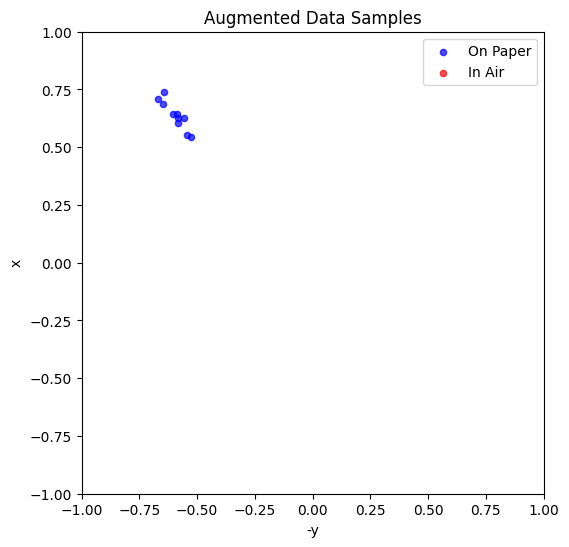

In [30]:
# Cell 5: Augmented Data Generation and Visualization
def generate_augmented_data(num_samples):
    # Generate random noise with the shape (num_samples, 3)
    noise = np.random.normal(size=(num_samples, 3))
    
    # Predict augmented data using the VAE model
    augmented_data = vae.predict(noise)
    return augmented_data

augmented_data = generate_augmented_data(10)

# Print the augmented data to check its values
print("Augmented data:", augmented_data)

# Plot augmented data
fig, ax = plt.subplots(figsize=(10, 6))

# Split based on pen_status
on_paper_aug = augmented_data[augmented_data[:, 2] >= 0.5]  # Treat values >= 0.5 as 'On Paper'
in_air_aug = augmented_data[augmented_data[:, 2] < 0.5]     # Treat values < 0.5 as 'In Air'

# Plotting
ax.scatter(-on_paper_aug[:, 1], on_paper_aug[:, 0], c='blue', s=20, alpha=0.7, label='On Paper')
ax.scatter(-in_air_aug[:, 1], in_air_aug[:, 0], c='red', s=20, alpha=0.7, label='In Air')

# Set appropriate limits to visualize the data
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_title('Augmented Data Samples')
ax.set_xlabel('-y')
ax.set_ylabel('x')
ax.legend()
ax.set_aspect('equal')
plt.show()
